## Businesses & Venues Data Analysis of Boston City
In this project, K-means clustering and data analysis were performed to provide contractors information to know where best to locate their business. This platform provides information about the density of venues in Boston City and highlights the neighborhoods with high concentration in dining, social activities and local/small business. With the use of the map visualization and the data visualization methods, better decisions can be made by contractors looking to opening a business e.g. retail, food or service venue in the Boston area.

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3 #library provides complete access to the IBM® Cloud Object Storage API

boston_data = pd.read_csv(body)
boston_data.head()

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493


### The Geocoder package is used with the arcgis_geocoder to obtain the latitude and longitude of the needed locations.

In [2]:
#Using geocoder package 
!pip install geocoder
import geocoder
#Creating a get the latitutode and longitude values of neighbourhoods
def get_latilong(neighborhood_name):
    # Using the Geocoder API and arcgis service (to find point locations of addresses, business names etc.) 
    g = geocoder.arcgis('{},Boston, MA'.format(neighborhood_name))
    lati_long_coords = g.latlng
    return lati_long_coords
#check the coordinates for neighborhood_name    
get_latilong('Roslindale') 

[42.28182009628248, -71.13710364030405]

In [3]:
#Get the coordinates of the neighborhoods using the function get_latilong
Neighborhood_names=boston_data['Name']
coords=[]
for neighborhood_name in Neighborhood_names:
    latlong=get_latilong(neighborhood_name)
    coords.append(latlong)
#Using a list comprehension
coords = [get_latilong(neighborhood_name) for neighborhood_name in Neighborhood_names] 

In [4]:
# Creating a dataframe for Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
#Adding the Latitude & Longitude columns to the dataset 
boston_data= pd.concat([boston_data, df_coords], axis=1, sort=False)
boston_data.head()

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,Latitude,Longitude
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,42.281820,-71.137104
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,42.305849,-71.119092
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,42.335710,-71.109800
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,42.337254,-71.103751
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,42.348165,-71.068470


#### Map Visualization

Using the geopy library for map visualization and the latitude and longitude values of Boston is obtained.


In [5]:
#Define a user_agent i.e. boston_explorer to define an instance of the geocoder 
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # to geolocate a query to an address and coordinates
geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode('Boston, MA') #adress 'Boston, MA'
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [6]:
#Create a map of Boston with it's neighbourhoods
!pip install folium
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # folium map rendering library 
map_boston= folium.Map(location=[latitude, longitude], zoom_start=12) #pass the coordinates to Folium
# Add markers to map
for lat, lng, label in zip(boston_data['Latitude'], boston_data['Longitude'], boston_data['Name']):
    label = folium.Popup(label)
    folium.CircleMarker([lat, lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7).add_to(map_boston)  
map_boston

The Foursquare API will be used to obtain the Boston Area venues for the geographical location data. These will be used to explore the neighbourhoods of Boston acordingly.

In [7]:
#Utilizing the Foursquare API to explore the neighborhoods and segment them
CLIENT_ID =  # Foursquare ID
CLIENT_SECRET = #F oursquare Secret
VERSION =  # Foursquare API version
LIMIT = 100;radius=500 # limit of number of venues returned by Foursquare API to the top 100 venues that are in each neighbourhood within a radius of 500 meters
Boston_latitude=latitude
Boston_longitude=longitude
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,CLIENT_SECRET, VERSION, Boston_latitude, Boston_longitude,radius,LIMIT)

### Data Exploration

Single Neighbourhood — a initial exploration of a single Neighbourhood within the Boston area was done to examine the Foursquare workability. 

In [8]:
# Resets the current index to a new
Roslindale_df = boston_data.reset_index().drop('index', axis = 1)
Roslindale_df.loc[Roslindale_df['Name'] == 'Roslindale']

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,Latitude,Longitude
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,42.28182,-71.137104


In [9]:
Roslindale_lat = Roslindale_df.loc[0,'Latitude']
Roslindale_long = Roslindale_df.loc[0,'Longitude']
Roslindale_name = Roslindale_df.loc[0,'Name']
print('The latitude and longitude values of {}, are {}, {}.'.format(Roslindale_name, Roslindale_lat, Roslindale_long))

The latitude and longitude values of Roslindale, are 42.28182009628248, -71.13710364030405.


Exploring the top 100 venues that are within a 500 metres radius of Roslindale. 

In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Roslindale_lat, 
    Roslindale_long, 
    radius, 
    LIMIT)

In [11]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
r = requests.get(url)
#Dealing with JSON data
results=r.json() #creates a dictionary of data
#results

In [12]:
#From the results, the necessary information needs to be obtained from items key.
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
#Find the nearby Venues, top 10 for Roslindale
venues = results['response']['groups'][0]['items']
# flatten JSON
nearby_venues = json_normalize(venues)
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,Fornax Bread Company,Bakery,42.286171,-71.129760
1,Pleasant Cafe,Italian Restaurant,42.278742,-71.136614
2,Delfino’s,Italian Restaurant,42.287106,-71.129470
3,Roslindale Village Farmers Market,Farmers Market,42.286534,-71.128509
4,Roslindale Square,Plaza,42.285815,-71.129304
5,Effie's Kitchen,Greek Restaurant,42.285899,-71.128741
6,Roslindale House Of Pizza,Pizza Place,42.287989,-71.126549
7,Sophia's Grotto,Italian Restaurant,42.286616,-71.129869
8,753 South,American Restaurant,42.287188,-71.129190
9,Porter Cafe,Bar,42.287251,-71.149334


In [14]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')
nearby_venues_lewisham_unique.head(5)

,Count
Pizza Place,9
Pharmacy,5
Bar,4
American Restaurant,4
Italian Restaurant,4


Multiple Neighbourhoods — expling Neighborhoods in the Boston area

In [15]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
r = requests.get(url)
#Dealing with JSON data
results=r.json() #creates a dictionary of data
#results

In [16]:
# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items'] #get the values from the dictionary
venues_list =[]
# return information for each nearby venue using the relevant keys 
for v in results:
    venues_list.append([v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']])
#print(venues_list)

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
         # extracting the information for each venue
        for v in results:
            venues_list.append([(name,lat,lng, #inputs from the function 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'])])
    [item for venue_list in venues_list for item in venue_list]
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
Boston_venues = getNearbyVenues(names=boston_data['Name'],
                                   latitudes=boston_data['Latitude'],
                                   longitudes=boston_data['Longitude']
                                  )

In [19]:
Boston_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Roslindale,42.28182,-71.137104,Pleasant Cafe,42.278742,-71.136614,Italian Restaurant
1,Roslindale,42.28182,-71.137104,J.J. Brannelly's,42.280286,-71.134635,Bar
2,Roslindale,42.28182,-71.137104,Pet Cabaret,42.281461,-71.133479,Pet Store
3,Roslindale,42.28182,-71.137104,MVP Liquors,42.283387,-71.131658,Liquor Store
4,Roslindale,42.28182,-71.137104,Las Palmas,42.283425,-71.131437,Latin American Restaurant


In [20]:
#Boston neighbourhood and venues 
Boston_venues.groupby('Neighborhood').count().head(5)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,28,28,28,28,28,28
Back Bay,100,100,100,100,100,100
Bay Village,47,47,47,47,47,47
Beacon Hill,41,41,41,41,41,41
Brighton,29,29,29,29,29,29


In [21]:
print('There are {} uniques categories.'.format(len(Boston_venues['Venue Category'].unique())))

There are 206 uniques categories.


In [22]:
#Top 5 Venue categories
Boston_venues['Venue Category'].value_counts().to_frame(name='Count').head()

,Count
Coffee Shop,53
Bakery,46
Pizza Place,40
Italian Restaurant,39
American Restaurant,38


### Clustering 

Analysing each Neighbourhood — check and explore the venues in each neighbourhood.

In [23]:
# One hot encoding- convert the categorical to 0 and 1's 
Boston_onehot = pd.get_dummies(Boston_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [24]:
# Neighborhood column is added back to dataframe
Boston_onehot['Neighborhood'] = Boston_venues['Neighborhood']

In [25]:
# Neighborhood column is moved to the first column
col = Boston_onehot.pop("Neighborhood")
Boston_onehot.insert(0, col.name, col)

In [26]:
#New one hot encoded dataframe 
Boston_onehot.head(5)

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Roslindale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Roslindale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Roslindale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Roslindale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Roslindale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#Regrouping and performing category Statistics
Boston_grouped = Boston_onehot.groupby('Neighborhood').mean().reset_index()

In [28]:
#Grouping  each Neighbourhoods with 10 common venues
num_top_venues = 10 # Top common venues needed
for hood in Boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Boston_grouped[Boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Allston----
                    venue  freq
0             Pizza Place  0.11
1         Bubble Tea Shop  0.04
2       Convenience Store  0.04
3                    Café  0.04
4  Furniture / Home Store  0.04
5      Burmese Restaurant  0.04
6              Shoe Store  0.04
7          Discount Store  0.04
8                     Gym  0.04
9           Bowling Alley  0.04


----Back Bay----
                venue  freq
0      Clothing Store  0.10
1         Coffee Shop  0.05
2           Bookstore  0.03
3       Grocery Store  0.03
4      Ice Cream Shop  0.03
5      Sandwich Place  0.03
6               Hotel  0.03
7          Restaurant  0.02
8  Seafood Restaurant  0.02
9       Deli / Bodega  0.02


----Bay Village----
                   venue  freq
0                Theater  0.13
1                  Hotel  0.09
2         Sandwich Place  0.06
3      French Restaurant  0.04
4  Performing Arts Venue  0.04
5             Steakhouse  0.04
6                 Bakery  0.04
7         Breakfast Spot  0.04
8   

Creating a new dataframe to put the common venues into pandas dataframe.

In [29]:
#Creating a function to return_most_common_venues to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
import numpy as np
num_top_venues = 3
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Boston_grouped['Neighborhood']
for ind in np.arange(Boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Boston_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Allston,Pizza Place,Hockey Rink,Burmese Restaurant
1,Back Bay,Clothing Store,Coffee Shop,Bookstore
2,Bay Village,Theater,Hotel,Sandwich Place
3,Beacon Hill,Hotel Bar,Pizza Place,French Restaurant
4,Brighton,Coffee Shop,Yoga Studio,Chinese Restaurant


### Clustering the Neighborhoods

In [31]:
Boston_grouped_clustering = Boston_grouped.drop('Neighborhood', 1)

Select the most optimal value of the K (no. of cluster) in K-means clustering using the elbow method

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


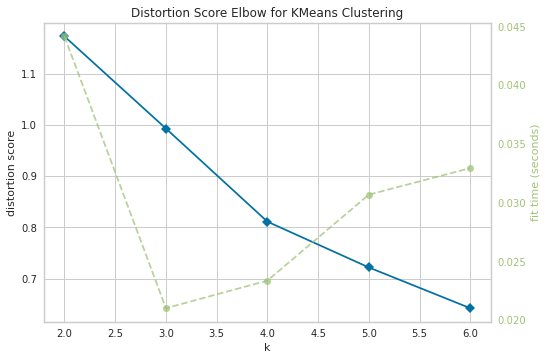

In [32]:
from sklearn.cluster import KMeans
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7))
# Fit the data to the visualizer
visualizer.fit(Boston_grouped_clustering)       
visualizer.poof()    

In [33]:
# Instantiate the KMeans models
from sklearn.metrics import silhouette_score
km = KMeans(n_clusters=4, random_state=42)
# Fit the KMeans model
km.fit_predict(Boston_grouped_clustering)
# Calculate Silhoutte Score
score = silhouette_score(Boston_grouped_clustering, km.labels_, metric='euclidean')
# Print the score
print('Silhouetter Score: %.3f' % score)
# check cluster labels generated for each row in the dataframe
km.labels_[0:5]

Silhouetter Score: 0.211


array([3, 0, 0, 0, 0], dtype=int32)

The silhouette score falls within the range [-1, 1].
The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
In this case the silhouette score suggest the cluster are not well separated and are sparse. 

Creating a new dataframe that includes the clusters as well as the top 10 venues for each neighbourhoods.

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', km.labels_)
neighborhoods_venues_sorted.head()


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,3,Allston,Pizza Place,Hockey Rink,Burmese Restaurant
1,0,Back Bay,Clothing Store,Coffee Shop,Bookstore
2,0,Bay Village,Theater,Hotel,Sandwich Place
3,0,Beacon Hill,Hotel Bar,Pizza Place,French Restaurant
4,0,Brighton,Coffee Shop,Yoga Studio,Chinese Restaurant


In [35]:
# merge Boston_grouped with Boston_data to add latitude/longitude for each neighborhood
boston_lat_lng=boston_data.rename(columns={"Name": "Neighborhood"})
merged_data=boston_lat_lng.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
new_data=merged_data.drop(['OBJECTID','Neighborhood_ID','ShapeSTArea','ShapeSTLength'],axis=1)
new_data.head()


,Neighborhood,Acres,SqMiles,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Roslindale,1605.568237,2.51,42.281820,-71.137104,2,Bar,Pet Store,Italian Restaurant
1,Jamaica Plain,2519.245394,3.94,42.305849,-71.119092,0,Park,Pet Store,Bakery
2,Mission Hill,350.853564,0.55,42.335710,-71.109800,0,Café,Sandwich Place,American Restaurant
3,Longwood,188.611947,0.29,42.337254,-71.103751,0,Café,Coffee Shop,Sushi Restaurant
4,Bay Village,26.539839,0.04,42.348165,-71.068470,0,Theater,Hotel,Sandwich Place


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
kclusters = 4
x = np.arange(kclusters)

ys = [i + x + (i*x)**2 for i in range(kclusters)]

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_data['Latitude'], new_data['Longitude'], new_data['Neighborhood'], new_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [37]:
for i in range(0,4):
    x=new_data.loc[new_data['Cluster Labels'] == i, new_data.columns[[1] + list(range(4, new_data.shape[1]))]]
    print("Cluster "+str(i+1))
    print((x.iloc[:,3:]))  

Cluster 1
   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue
1                   Park             Pet Store                Bakery
2                   Café        Sandwich Place   American Restaurant
3                   Café           Coffee Shop      Sushi Restaurant
4                Theater                 Hotel        Sandwich Place
5    American Restaurant                   Gym      Department Store
6     Chinese Restaurant                Bakery      Asian Restaurant
7     Italian Restaurant           Pizza Place                Bakery
9               Wine Bar               Theater   American Restaurant
10        Clothing Store           Coffee Shop             Bookstore
11    Chinese Restaurant                Bakery           Coffee Shop
12           Pizza Place                 Hotel                   Bar
13                 Hotel                   Bar           Pizza Place
14             Hotel Bar           Pizza Place     French Restaurant
15                 Hotel

### Results

1. Restaurants, coffee Shops, bars, hotels, museums, historical sites, parks and shopping stores are common in cluster 1. This indicates this cluster has areas for tourism and recreation in Boston.
2. International restaurants are very common and varied in cluster 1. In cluster 3, there are bars and restaurants but they are less diverse and varied.
3. Cluster 2 seems to be for residential nearby shops as it includes home services and few shops.
4. Cluster 4 has areas with open and green space due to presence of Landscaping & construction and Hockey rinks. Therefore, this cluster seems to be a suburban residential area as it also has few restaurants and shops.
5. The clusters have variations, but there isn't a dominant presence of a venue in cluster 2 and 3 as there is one observation in each.


### Conclusion and Future work

Cluster 1 provides location to open businesses related to tourism or recreational activities. It is also the best place to open an international restaurant, such as Chinese, Indian, America, and Italian. Cluster 4 is best to open businesses related to residential living and for landscaping. This can include services such as snow management or backyard construction. Although, this analysis provides some insights for contractors to open a business e.g. retail, food or service venue in the Boston area, however more neighborhood data needs to be extracted to provide more robust decisions.
Clustering uses all features of the data in an attempt to learn as much as possible and produce clusters/ distinct groups. From our dataset, the clusters were not very dense and well separated. In order to improve the performance of the k-means clustering algorithm Principal Component Analysis (PCA) which is an important approach to unsupervised dimensionality reduction and feature weight learning have been used.
